In [39]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from PIL import Image

class Kmeans_img:
    """
    Implement a simple Kmeans algorithm to compress the color values in a image.

    Parameters
    ------------
    n_clusters: int, optional, default: 8
        The number of clusters to form as well as the number of
        centroids to generate.

    max_iter: int, default: 100
        Maximum number of iterations of the k-means algorithm for a
        single run.
    init: {'k-means++', 'random' }
        Method for initialization, defaults to 'random'. Not implemented kmeans++ yet. 
    n_init: int, default: 1
        Number of times the algorithm will run.
        It will return the model with minimum total within cluster variance.
    seed: int, default: 7
        The seed for randomizing the cluster centers. 

    Attributes
    ----------
    cluster_centers_ : array, [n_clusters, n_features]
        Coordinates of cluster centers. If the algorithm stops before fully
        converging (see ``tol`` and ``max_iter``), these will not be
        consistent with ``labels_``.

    labels_ :
        Labels of each point

    tot_cluster_vars_ : float
        Sum of squared distances of samples to their closest cluster center.

    """
    def __init__(self, n_clusters = 8, max_iter = 100, tol=10**(-5), init = "random", n_init = 1,seed=7):
        assert isinstance(n_clusters,int), "Enter an Integer for the number of clusters like 5."
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol= tol
        self.init = init
        self.n_init = n_init
        self.seed = seed
        
       
    # initialize the cluster centers with random method

    def _init_cluster_centers_random(self, data):
        init_cluster_centers = pd.DataFrame(np.random.randint(data.min().min(),data.max().max()
                                                              ,size=(self.n_clusters, data.shape[1]))
                                            ,index= range(self.n_clusters),columns = data.columns)
        self.cluster_centers_ = init_cluster_centers
        return self.cluster_centers_
        


    def _kmeans_distance(self,data):
        # initialize the data frame to be all zeros to hold the distance value.
        # each row is the cluster number, each column is the distance of each data point to the centroid.
        distance_df = pd.DataFrame(index=range(self.n_clusters),columns= data.index)
        distance_df = distance_df.fillna(0)

        # assign the value of L2 norm distance to the centroid to each row of the distance_df
        for i in range(self.cluster_centers_.shape[0]):
            distance_df.iloc[i] = np.square(data-self.cluster_centers_.iloc[i]).sum(axis=1)

        # return the distance dataframe
        return distance_df

    def _kmeans_iter(self, data):
        # calculate the distance matrix
        distance_dataframe = self._kmeans_distance(data)

        # calculate the current new cluster assignments.
        new_cluster_assignment = [0]*data.shape[0]
        for index in range(len(new_cluster_assignment)):
            new_cluster_assignment[index] = distance_dataframe.iloc[:,index].idxmin()
        # finished with cluster assignment, the cluster labels are now in a list.

        # initialize the dataframe to store new centroid positions.
        new_centroid = pd.DataFrame(index= range(self.n_clusters),columns = data.columns)
        
        # initialize a list to store the within cluster variance to measure if the cluster converges.
        new_centroid_variance = [0]*self.n_clusters

        # iterate through all possible cluster number, and calculates the new centroid positions using the mean.
        for cluster_value in range(self.n_clusters):
            # get the index for new cluster assignment.
            cluster_data_index = [new_cluster_value_index for new_cluster_value_index,new_cluster_value in enumerate(new_cluster_assignment) if new_cluster_value == cluster_value]
            # get the data belonging to cluster "cluster_value"
            cluster_data = data.iloc[cluster_data_index]
            # calculate the centroid position using the mean for each feature.
            new_centroid_position = cluster_data.mean(axis=0)
            # calculate the within-cluster variance.
            new_centroid_variance[cluster_value] = cluster_data.var(axis = 0).sum(axis = 0)
            # assign this value to the value for the new_centroid positions.
            new_centroid.iloc[cluster_value] = new_centroid_position
            
        # assign the new cluster centers, total cluster variance and new cluster assignments
        self.tot_cluster_vars_ = sum(new_centroid_variance)
        self.cluster_centers_ = new_centroid
        self.labels_ = new_cluster_assignment
        
        return self.tot_cluster_vars_, new_centroid



    def fit(self,data):
        # initialize the position with some random value.
        np.random.seed(self.seed)
        self._init_cluster_centers_random(data)

        for i in tqdm(range(self.max_iter)):
            # create a copy of the current centroid positions
            old_centroids_positions = self.cluster_centers_.copy()
            # do one iteration of the kmeans algorithm and return the variance of the centroids and new centroid positions.
            new_centroids_variances, new_positions = self._kmeans_iter(data)


            # test to see if the new position contains any NA values.
            # if it contains NA values then you need to re-initialize the centroid positions.
            if new_positions.isnull().sum().sum() !=0:
                np.random.seed(self.seed+i)
                self.cluster_centers_= self._init_cluster_centers_random(data)


            # calculate the squared differences in the cnetroid position change after one iterations.
            positions_sq_diff = np.square(old_centroids_positions-new_positions).sum(axis=0).sum()

            # if the change in the squared difference is smaller than the tol value then the iteration is stopped.
            if positions_sq_diff < self.tol:
                break


        return self.cluster_centers_
    
    def predict(self, newdata):
        # calculate the distance matrix 
        distance_dataframe = self._kmeans_distance(newdata)
    
        # calculate the current new cluster assignments.
        new_cluster_assignment = [0]*newdata.shape[0]
        for index in range(len(new_cluster_assignment)):
        
            new_cluster_assignment[index] = distance_dataframe.iloc[:,index].idxmin()
    
        return new_cluster_assignment
    
    def transform(self, newdata):
        # generate the cluster labels from the distance metric.
        cluster_labels = self.predict(newdata)
    
        # initialize new dataframe for storing the compressed data
        new_compressed_img_data = pd.DataFrame(index= range(newdata.shape[0]),columns = newdata.columns)
        for index, cluster_label in enumerate(cluster_labels):
             new_compressed_img_data.iloc[index] = self.cluster_centers_.iloc[cluster_label]
    
        return new_compressed_img_data
    
        
    @staticmethod
    def read_tiff(path):
        # read the tiff image data
        im = Image.open(path)
        # convert it into a numpy array
        image = np.array(im)
        # return the numpy array for furthur processing.
        return image
    @staticmethod
    def from_np_to_pd(data):
        # reshaped the input data
        data_reshaped = data.reshape(data.shape[0]*data.shape[1],3)
        # convert it to a pandas dataframe
        reshaped_df = pd.DataFrame(data_reshaped)
        
        return reshaped_df
    
    @staticmethod
    def from_pd_to_img(data,img):
        # get the data values from pandas dataframe
        data = data.values
        # reshape the numpy array into original image format. 
        data_reshaped = data.reshape(img.shape[0],img.shape[1],3)
        # convert to unit8 data type
        img_unit8 = np.uint8(data_reshaped)
        # convert to image from numpy array
        img = Image.fromarray(img_unit8)
        
        return img
    
    def __repr__(self):
        string = "Kmeans_img(n_clusters = {}, max_iter = {}, tol={}, init = '{}', n_init = {}, seed={})".format(self.n_clusters,
                                                                                                            self.max_iter,
                                                                                                           self.tol,
                                                                                                           self.init,
                                                                                                           self.n_init,self.seed)
        return string
    
        


Some test cases

In [40]:
train_data2 = pd.DataFrame([[-1,1],[1,-1],[1.01,-1.01]
                           ,[-1.01,1.01],[1.02,-1.02]
                           ,[-1.02,1.02],[1.03,-1.03]
                           ,[-1.03,1.03]], columns = ["f1",'f2'])


test_data2 = pd.DataFrame([[-1.2,1.2],[1.2,-1.2]], columns = ["f1",'f2'])



train_data3 = pd.DataFrame([[-1,1,-1],[1,-1,1]
                           ,[1.01,-1.01,1.01]
                           ,[-1.01,1.01,-1.01]
                           ,[1.02,-1.02,1.02]
                           ,[-1.02,1.02,-1.02]
                           ,[1.2,-1.2,1.2]
                           ,[-1.2,1.2,-1.2]], columns = ["f1",'f2','f3'])


test_data3 = pd.DataFrame([[-1.3,1.3,-1.3],[1.3,-1.3,1.3]
                          ], columns = ["f1",'f2','f3'])

kmeans_2 = Kmeans_img(n_clusters = 2)
kmeans_2.fit(train_data2)
kmeans_2.predict(test_data2)

  0%|          | 0/100 [00:00<?, ?it/s]


[1, 0]

In [41]:
kmeans_2

Kmeans_img(n_clusters = 2, max_iter = 100, tol=1e-05, init = 'random', n_init = 1, seed=7)

In [42]:
Kmeans_img(n_clusters = 2.5) 

AssertionError: Enter an Integer for the number of clusters like 5.

In [23]:
kmeans_3 = Kmeans_img(n_clusters = 2)
kmeans_3.fit(train_data3)
kmeans_3.predict(test_data3)

  0%|          | 0/100 [00:00<?, ?it/s]


[1, 0]

In [24]:
kmeans_3

Kmeans_img(n_clusters = 2, max_iter = 100, tol=1e-05, init = 'random', n_init = 1, seed=7)

## Apply the kmeans algorithm to the image data for vector quantization. 

In [25]:
# read in the tiff data and convert it into a format that can be processed by kmeans.
image_np = Kmeans_img.read_tiff("./peppers.tiff")

image_df = Kmeans_img.from_np_to_pd(image_np)

In [26]:
kmeans_img = Kmeans_img(n_clusters = 16, max_iter=500)

kmeans_img.fit(image_df)

100%|██████████| 500/500 [27:44<00:00,  3.33s/it]


,0,1,2
0,52,14,207
1,148,47,15
2,137,196,158
3,82,171,184
4,227,170,68
5,33,207,123
6,76,139,148
7,193,205,184
8,86,225,118
9,8,39,203


In [27]:
compressed_img_df = kmeans_img.transform(image_df)

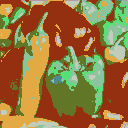

In [28]:
Kmeans_img.from_pd_to_img(compressed_img_df,image_np)

In [29]:
kmeans_img.tot_cluster_vars_

9797.1826584256487

In [32]:
isinstance(5,int)

True